# People

What are they? How can we represent people in a meaningful way that doesn't get any of us fired for exfiltrating data?

## Faker

Let's generate some fake data! https://faker.readthedocs.io/en/master/




In [78]:
from faker import Faker
fake = Faker()

POPULATION = 3

people = [{
    **fake.profile() # lots of great stuff in here!
} for _ in range(POPULATION)]

people

[{'job': 'Magazine journalist',
  'company': 'Vasquez PLC',
  'ssn': '231-97-4534',
  'residence': 'PSC 1762, Box 0888\nAPO AE 38306',
  'current_location': (Decimal('61.3158685'), Decimal('70.862564')),
  'blood_group': 'A-',
  'website': ['https://www.malone.biz/'],
  'username': 'johnsonsteven',
  'name': 'Elizabeth Gonzalez',
  'sex': 'F',
  'address': '84650 Gomez Stravenue\nReeseton, AS 68595',
  'mail': 'sean29@gmail.com',
  'birthdate': datetime.date(1948, 7, 25)},
 {'job': 'Environmental consultant',
  'company': 'Blevins, Davis and Mercer',
  'ssn': '490-18-4531',
  'residence': '5135 Daniel Mall Apt. 591\nLake James, UT 32433',
  'current_location': (Decimal('-80.725110'), Decimal('-46.800265')),
  'blood_group': 'A-',
  'website': ['https://www.garza-lee.org/'],
  'username': 'vhull',
  'name': 'Miss Katrina Reed',
  'sex': 'F',
  'address': '6933 Heidi Walk Apt. 979\nNorth Karen, VI 25420',
  'mail': 'rodonnell@hotmail.com',
  'birthdate': datetime.date(2019, 3, 5)},
 {'jo

This is a good start but ... it's kind of wonky. We have people all over the world with so many different jobs! Let's keep the spirit of this but implement some of our own limitations on fields to ensure things line up with what we'd expect a company org to look like

In [260]:
import numpy as np
import random


def choose_a_few(
    options: list[str],
    weights: list[int | float] = None,
    max_choices: int = None,
    min_choices: int = 0,
) -> set[str]:
    max_choices = np.clip(max_choices or len(options), min_choices, len(options))
    
    # how many choices will we make this time?
    divisor = max_choices * (max_choices + 1) / 2    
    k_weights = [int(x) / divisor for x in range(max_choices, min_choices-1, -1)]
    n_choices = np.random.choice(list(range(min_choices,max_choices+1)), p=k_weights)
    
    # make the choices
    choices = random.choices(options, weights=weights, k=n_choices)
    return set(choices)


In [374]:
import pandas as pd
import numpy as np
from faker import Faker
import random

# create some fake data
fake = Faker()

employment = {"Full Time": 0.7, "Part Time": 0.05, "Contract": 0.3}
languages = {
    "Python": 0.25,
    "Scala": 0.1,
    "Go": 0.08,
    "JavaScript": 0.3,
    "Java": 0.3,
    "Typescript": 0.17,
    "Erlang": 0.01,
    "Elixir": 0.001,
}

def make_person() -> dict[str]:
    return {
        "Name": fake.name(),
        "Hire Date": fake.date_between(start_date="-3y", end_date="today"),
        "Status": choose_a_few(list(employment), max_choices=1, min_choices=1),
        "Languages": choose_a_few(list(languages.keys()), weights=list(languages.values())),
        "Team": None, # hrmmmm this is harder
        "Job": None, # let's be smarter with this
        "Country": None, # let's also be smarter with this
    }

make_person()

{'Name': 'Carol Thompson',
 'Hire Date': datetime.date(2022, 11, 2),
 'Status': {'Contract'},
 'Languages': set(),
 'Team': None,
 'Job': None,
 'Country': None}

Now we can generate more complex attributes in a smart way. Let's set up some rules about where offices are, what teams are in which offices, then pick titles based on other info (e.g. Developers probably know at least one language ... and executives are fulltime?)

In [409]:
from dataclasses import dataclass
from enum import Enum, auto


class timezone(str, Enum):
    EST = auto()
    PST = auto()
    UTC = auto()


@dataclass
class Location:
    city: str
    tz: timezone
    country: str

TEAM_TITLES = {
    "DevX": ["Engineer", "Engineer", "Engineer", "Engineer", "Engineer", "AVP"],
    "DevOps": ["Engineer", "Senior Engineer", "Manager"],
    "Sales": ["Associate"],
    "Support": ["Analyst", "Manager"],
    "Platform": ["Engineer", "Senior Engineer","Managing Engineer", "AVP", "VP"],
    "Product": ["Engineer", "Manager", "Product Owner", "AVP", "VP"],
    "Internal Tools": ["Engineer", "Senior Engineer", "Manager", "AVP", "VP"],
    "Business": ["Analyst", "Associate", "Vice President", "Director", "Managing Director"]
}


def title_city_team():
    # just a few locations
    offices = {
        location.city: location
        for location in [
            Location("New York", tz="EST", country="USA"),
            Location("Seattle", tz="PST", country="USA"),
            Location("Toronto", tz="EST", country="CAN"),
            Location("London", tz="UTC", country="GBR"),
            Location("Fort Lauderdale", tz="EST", country="USA"),
            Location("Dublin", tz="UTC", country="IRL"),
        ]
    }
    # codify the hierarchical structure
    allowed_teams_per_office = {
        "New York": ["Sales", "Product", "Business"],
        "Toronto": ["Platform", "Product", "Internal Tools", "Sales", "Business"],
        "Fort Lauderdale": ["DevX"],
        "Dublin": ["DevOps", "Support"],
        "London": ["Sales", "Business"],
        "Seattle": ["Internal Tools", "Product", "Platform"],
    }
    allowed_titles_per_team = TEAM_TITLES

    city = random.choice(list(offices))
    team = random.choice(allowed_teams_per_office[city])
    title = choose_a_few(
        allowed_titles_per_team[team], max_choices=1, min_choices=1
    ).pop()
    return {
        "City": city,
        "Timezone": offices[city].tz,
        "Country": offices[city].country,
        "Title": title,
        "Team": team,
    }


title_city_team()


{'City': 'London',
 'Timezone': 'UTC',
 'Country': 'GBR',
 'Title': 'Associate',
 'Team': 'Sales'}

After running this we should have a better balanced org in terms of region + titles. Then we just need to add the connections in -- i.e. who's the boss?!

In [410]:
def make_person() -> dict[str]:
    title_city_team_ = title_city_team()
    technical = 1 if "Engineer" in title_city_team_["Title"] else 0
    return {
        "Name": fake.name(),
        "Hire Date": fake.date_between(start_date="-3y", end_date="today"),
        "Status": choose_a_few(list(employment), max_choices=1, min_choices=1).pop(),
        "Languages": choose_a_few(list(languages.keys()), weights=list(languages.values()), min_choices=technical),
        **title_city_team_,
    }


In [510]:
people_df = pd.DataFrame((make_person() for _ in range(150)))
people_df.head()

,Name,Hire Date,Status,Languages,City,Timezone,Country,Title,Team
0,Rachel Jordan,2023-01-25,Part Time,{Typescript},London,UTC,GBR,Associate,Business
1,Vanessa Miles,2021-09-01,Part Time,{Java},Toronto,EST,CAN,Associate,Business
2,Vanessa Walker,2020-09-15,Full Time,"{JavaScript, Python}",Dublin,UTC,IRL,Engineer,DevOps
3,Rachel Sandoval,2021-03-25,Contract,"{Go, Java, JavaScript, Python}",New York,EST,USA,Analyst,Business
4,Brian Carlson,2021-05-08,Part Time,"{JavaScript, Scala, Java}",Toronto,EST,CAN,Senior Engineer,Internal Tools


So, let's group by Team and then pick a manager for everyone:

In [511]:
ranks = {team: {title: rank for rank,title in enumerate(titles)} for team, titles in TEAM_TITLES.items()}
for team in ranks:
    people_df.loc[people_df.Team==team, "rank"] = people_df.loc[people_df.Team==team].Title.map(ranks[team])
people_df = people_df.sort_values(by=["Team","rank"])

In [512]:
def naivereportsto(row, df):
    supervisor = (
        df[(df.index < row.name)].query(f"""rank <= {row["rank"]}-1""").tail(1).Name
    )
    supervisor = supervisor.item() if not supervisor.empty else None
    peer = df[(df.index < row.name)].query(f"""rank  == {row["rank"]}""").head(1).Name
    peer = peer.item() if not peer.empty else None
    return supervisor or peer or row.Name


def reportsto(df):
    return df.assign(manager=df.apply(naivereportsto, df=df, axis=1))


def supervisors(df):
    df["peoplemanager"] = df.apply(naivereportsto, df=df, axis=1)
    df = df.groupby("Team", group_keys=False).apply(reportsto).reset_index(drop=True)
    return df


people_df = people_df.pipe(supervisors)
people_df.head(5)


,Name,Hire Date,Status,Languages,City,Timezone,Country,Title,Team,rank,peoplemanager,manager
0,Rachel Sandoval,2021-03-25,Contract,"{Go, Java, JavaScript, Python}",New York,EST,USA,Analyst,Business,0.0,Vanessa Walker,Rachel Sandoval
1,Michael Sloan,2022-11-09,Contract,{JavaScript},London,UTC,GBR,Analyst,Business,0.0,Rachel Sandoval,Rachel Sandoval
2,Isaac Bowers,2020-12-29,Full Time,"{Go, Scala, JavaScript, Python, Typescript, Java}",London,UTC,GBR,Analyst,Business,0.0,Rachel Sandoval,Rachel Sandoval
3,Christopher Gonzalez,2022-02-12,Full Time,{Typescript},New York,EST,USA,Analyst,Business,0.0,Rachel Sandoval,Rachel Sandoval
4,Douglas Oconnor,2023-03-06,Part Time,"{Java, JavaScript, Python}",New York,EST,USA,Analyst,Business,0.0,Rachel Sandoval,Rachel Sandoval


Now we just need a CEO for all the team leads to report to:

In [513]:
CEO = make_person() | {"Team":"CEO", "Title":"CEO", "Status":"Full Time"}
people_df = pd.concat([people_df, pd.DataFrame([CEO])])
people_df.loc[people_df.manager == people_df.Name,"manager"]=CEO["Name"]

In [514]:
Cool .. this seems reasonably distributed?

Object `distributed` not found.


In [515]:
import plotly.express as px
px.histogram(people_df, x="Title", template="plotly_dark")

Quick Visualize

In [526]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(((person["Name"], person) for person in people_df.to_dict(orient="records")), attr="people")
G.add_edges_from(people_df[["Name","manager"]].dropna().values.tolist())

Ya, that's an org chart!

In [545]:
colors = dict(zip(people_df.Team.unique(),px.colors.qualitative.Vivid))
def rgb_to_hex(r, g, b):
    return f'#{r:02x}{g:02x}{b:02x}'
def rgb_string_to_tuple(rgb:str) -> tuple[int,int,int]:
    return tuple(int(c) for c in rgb.replace("rgb(","").replace(")","").split(","))

In [549]:
node_colors = [rgb_to_hex(*rgb_string_to_tuple(colors[team])) for _,team in G.nodes(data="Team")]

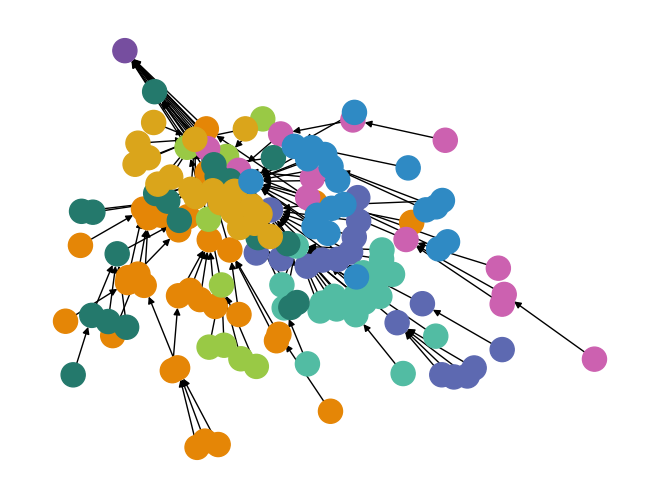

In [551]:
nx.draw(G, node_color=node_colors)